<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/arize-logo-white.jpg" width="200"/>
        <br>
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://arize.com/docs/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://arize-ai.slack.com/join/shared_invite/zt-2w57bhem8-hq24MB6u7yE_ZF_ilOYSBw#/shared-invite/email">Community</a>
    </p>
</center>
<h1 align="center">Agent Tool Parameter Extraction Classification Evals</h1>

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to evaluating agent tool parameter extraction,
- to provide an experimental framework for users to iterate and improve on the default agent tool parameter extraction template.

## Install Dependencies and Import Libraries

In [19]:
%pip install -qq "arize-phoenix-evals>=0.22.0" "openai>=1" ipython matplotlib pycm pyarrow opentelemetry-sdk scikit-learn arize tiktoken nest_asyncio 'httpx<0.28'
%pip install "arize[Datasets]" opentelemetry-sdk
%pip install openai pandas seaborn
%pip install "anthropic>=0.18.0"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [3]:
import nest_asyncio

nest_asyncio.apply()

In [ ]:
import json
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from pycm import ConfusionMatrix

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of a few example user prompts, with corresponding tool choices and ground truth answers, in addition to an evaluation prompt template against benchmark datasets of user queries and the corresponding tools called with ground-truth labels. We will be using the Berkely Function-Calling Leaderboard dataset. This dataset is commonly used for Agent applications that call tools as a benchmark.

In [5]:
!wget -O exec_simple.json https://huggingface.co/datasets/gorilla-llm/Berkeley-Function-Calling-Leaderboard/blob/main/BFCL_v3_exec_multiple.json

zsh:1: command not found: wget


In [ ]:
import requests

# Load dataset
url = "https://huggingface.co/datasets/gorilla-llm/Berkeley-Function-Calling-Leaderboard/resolve/main/BFCL_v3_exec_multiple.json"
response = requests.get(url)
dataset = [json.loads(line) for line in response.text.strip().splitlines()]

# Collect all unique tool definitions (these are all the tools the agent
# can choose from, as well as their parameters)
unique_tools = {}
for entry in dataset:
    for tool in entry.get("function", []):
        if tool["name"] not in unique_tools:
            unique_tools[tool["name"]] = tool

tool_definitions_text = "\n".join(
    f"{tool['name']}: {tool['description']} | Parameters: {json.dumps(tool['parameters'])}"
    for tool in unique_tools.values()
)


# Prepare data for evaluation
eval_data = []
for entry in dataset:
    question = entry["question"][0][0]["content"]
    ground_truths = entry.get("ground_truth", [])
    for gt in ground_truths:
        eval_data.append(
            {
                "question": question,
                "tool_call": gt,
                "tool_definitions": tool_definitions_text,
            }
        )

df_eval = pd.DataFrame(eval_data)
df_eval.head()

## Modify Benchmark Dataset

The BFCL Dataset does not have any `negative` examples, i.e. only `question`, `available_tools`, and `ground_truth` are present. In order to accurately benchmark our LLM-as-a-Judge, this code snippet appends some `incorrect` examples to our dataset, by adding 20 rows of data where the `incorrect` tool is selected with correspondingly incorrect parameters.

In [7]:
import json
import random
import re


# Parse tool definitions into a dict: tool_name -> list of required parameters
def extract_tool_param_templates(tool_definitions):
    tools = {}
    pattern = r"^(\w+):.*?\| Parameters: (.*)$"
    for line in tool_definitions.strip().split("\n"):
        match = re.match(pattern, line.strip())
        if match:
            name, param_json = match.groups()
            try:
                param_schema = json.loads(param_json)
                required = param_schema.get("required", [])
                tools[name] = required
            except json.JSONDecodeError:
                continue
    return tools


tool_param_templates = extract_tool_param_templates(tool_definitions_text)
tool_names = list(tool_param_templates.keys())

# Sample 20 wrong examples
wrong_examples = []
for i in range(20):
    row = df_eval.iloc[i]
    question = row["question"]
    correct_tool_call_str = row["tool_call"]

    # Get correct tool name (assume it's before the first '(')
    try:
        correct_tool_name = correct_tool_call_str.split("(")[0]
    except Exception as e:
        print(f"Skipping row {i} due to error: {e}")
        continue

    # Get a different tool
    incorrect_tools = [tool for tool in tool_names if tool != correct_tool_name]
    if not incorrect_tools:
        continue

    wrong_tool = random.choice(incorrect_tools)
    required_params = tool_param_templates.get(wrong_tool, [])

    # Build dummy argument string
    dummy_args = []
    for param in required_params:
        dummy_value = random.choice(
            [42, 3.14, '"example"', "[1, 2, 3]", "True"]
        )  # random but plausible
        dummy_args.append(f"{param}={dummy_value}")

    wrong_tool_call = f"{wrong_tool}({', '.join(dummy_args)})"

    wrong_examples.append(
        {
            "question": question,
            "tool_call": wrong_tool_call,
            "tool_definitions": tool_definitions_text,
        }
    )

# Create and label the correct examples
df_eval["true_label"] = "correct"

# Create and label the incorrect examples
df_wrong = pd.DataFrame(wrong_examples)
df_wrong["true_label"] = "incorrect"

# Combine both datasets
df_combined = pd.concat([df_eval, df_wrong], ignore_index=True)

# OPTIONAL: Shuffle AFTER labeling
df_eval_final = df_combined.sample(frac=1).reset_index(drop=True)

## Display Agent Tool Parameter Extraction Prompt Template

View the default template used to evaluate agent tool parameter extraction.
You can tweak this template and evaluate its performance relative to the default.

In [8]:
TOOL_PARAMETER_EXTRACTION_PROMPT_TEMPLATE = """
You are an evaluation assistant assessing whether the parameters provided in a tool call correctly
match the user's question. Your task is to decide if the parameters selected are correct and
sufficient to answer the question, using only the list of available tools and their parameter
definitions provided below. You are not responsible for checking if the correct tool was selected
— assume the tool is correct. You are evaluating **only** whether the parameters are accurate and
justified based on the content of the question.

Think like a grading rubric. Be strict. If the parameters are not clearly correct based on the
question alone, label them "incorrect". Do not make assumptions or infer values that are not
explicitly stated or directly supported by the question. Only use the information provided.

Your response must be a **single word**: either `"correct"` or `"incorrect"`.
Do not include any explanation, punctuation, or other characters. The output will be parsed
programmatically.

---
Label the parameter extraction as `"correct"` if **all** of the following are true:
- All required parameters are present and correctly filled based on the question
- The parameter values are explicitly justified by the question
- No extra, irrelevant, or hallucinated parameters are included

Label the parameter extraction as `"incorrect"` if **any** of the following are true:
- Any required parameter is missing, malformed, or incorrectly populated
- Any parameter value is inferred or not clearly supported by the question
- Any extra or irrelevant parameter is included
---

[BEGIN DATA]
************
[Question]: {question}
************
[Tool Called With Parameters]: {tool_call}
************
[END DATA]

[Tool Definitions]: {tool_definitions}
"""

Eval template variables:

- **question** : The question the user poses
- **tool_call** : The tool that is actually called (ground truth)
- **tool_definitions** : All the available tools to the agent

## Configure the LLM

Configure your API keys.

In [9]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")

openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key


# Set Anthropic API key
if not (anthropic_api_key := os.getenv("ANTHROPIC_API_KEY")):
    anthropic_api_key = getpass("🔑 Enter your Anthropic API key: ")

os.environ["ANTHROPIC_API_KEY"] = anthropic_api_key

## Evaluate the Dataset Using Phoenix

In [ ]:
from tqdm import tqdm

from phoenix.evals import (
    create_classifier,
    evaluate_dataframe,
)
from phoenix.evals.llm import LLM

# List of OpenAI model codes to benchmark
open_ai_models = [
    "gpt-4o",  # GPT-4 Omni (May 2024)
    "gpt-4o-mini",  # Smaller version of GPT-4o
    "gpt-4",  # GPT-4 (March 2023)
    "gpt-4-turbo",  # GPT-4 Turbo (November 2023)
    "gpt-4-turbo-2024-04-09",  # GPT-4 Turbo snapshot (April 2024)
    "gpt-3.5-turbo",  # GPT-3.5 Turbo (March 2023)
    "gpt-3.5-turbo-0125",  # GPT-3.5 Turbo snapshot (January 2025)
    "o1",  # OpenAI's first reasoning model
    "o1-mini",  # Smaller version of o1
    "o3",  # Successor to o1 with improved reasoning
    "o3-mini",  # Smaller version of o3
    "o4-mini",  # Latest mini reasoning model (April 2025)
]

all_results = []

# ---------- Evaluate OpenAI Models ----------
for model_name in tqdm(open_ai_models):
    print(f"\n🧪 Evaluating OpenAI model: {model_name}")

    model = LLM(provider="openai", model=model_name)

    tool_param_eval = create_classifier(
        name="tool parameter extraction",
        prompt_template=TOOL_PARAMETER_EXTRACTION_PROMPT_TEMPLATE,
        llm=model,
        choices={"correct": 1.0, "incorrect": 0.0},
    )

    results_df = evaluate_dataframe(dataframe=df_eval, evaluators=[tool_param_eval])

    results_df["label"] = results_df["tool parameter extraction_score"].apply(
        lambda x: x.get("label") if isinstance(x, dict) else None
    )
    results_df["model"] = results_df["tool parameter extraction_score"].apply(
        lambda x: x.get("metadata").get("model") if isinstance(x, dict) else None
    )
    all_results.append(results_df)

  0%|          | 0/1 [00:00<?, ?it/s]


🧪 Evaluating OpenAI model: gpt-4o


Evaluating Dataframe |          | 0/50 (0.0%) | ⏳ 00:00<? | ?it/s

100%|██████████| 1/1 [02:53<00:00, 173.63s/it]


In [ ]:
all_results

## Evaluate Anthropic Models

In [ ]:
# ---------- Evaluate Anthropic Models ----------

# List of Claude (Anthropic) models to benchmark
anthropic_models = [
    "claude-3-opus-20240229",  # Claude 3 Opus
    "claude-3-sonnet-20240229",  # Claude 3 Sonnet
    "claude-3-haiku-20240307",  # Claude 3 Haiku
    "claude-opus-4-20250514",  # Claude Opus 4
    "claude-sonnet-4-20250514",  # Claude Sonnet 4
]


for model_name in tqdm(anthropic_models):
    print(f"\n🧪 Evaluating Anthropic model: {model_name}")

    model = LLM(provider="anthropic", model=model_name)

    tool_param_eval = create_classifier(
        name="tool parameter extraction",
        prompt_template=TOOL_PARAMETER_EXTRACTION_PROMPT_TEMPLATE,
        llm=model,
        choices={"correct": 1.0, "incorrect": 0.0},
    )

    results_df = evaluate_dataframe(dataframe=df_eval, evaluators=[tool_param_eval])

    results_df["label"] = results_df["tool parameter extraction_score"].apply(
        lambda x: x.get("label") if isinstance(x, dict) else None
    )
    results_df["model"] = results_df["tool parameter extraction_score"].apply(
        lambda x: x.get("metadata").get("model") if isinstance(x, dict) else None
    )
    all_results.append(results_df)

## Show Results

Let's see how well different models performed as a Judge! We'll show:
- Confusion Matrix for one model (GPT 4o)
- F1 score per model benchmarked, to compare how different models perform as a judge vs the ground truth
-  An agreement matrix to see which models agree with each other as judges.

/var/folders/gg/2586gdl96294y9xs_3j3l7t00000gp/T/ipykernel_75032/1014510063.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


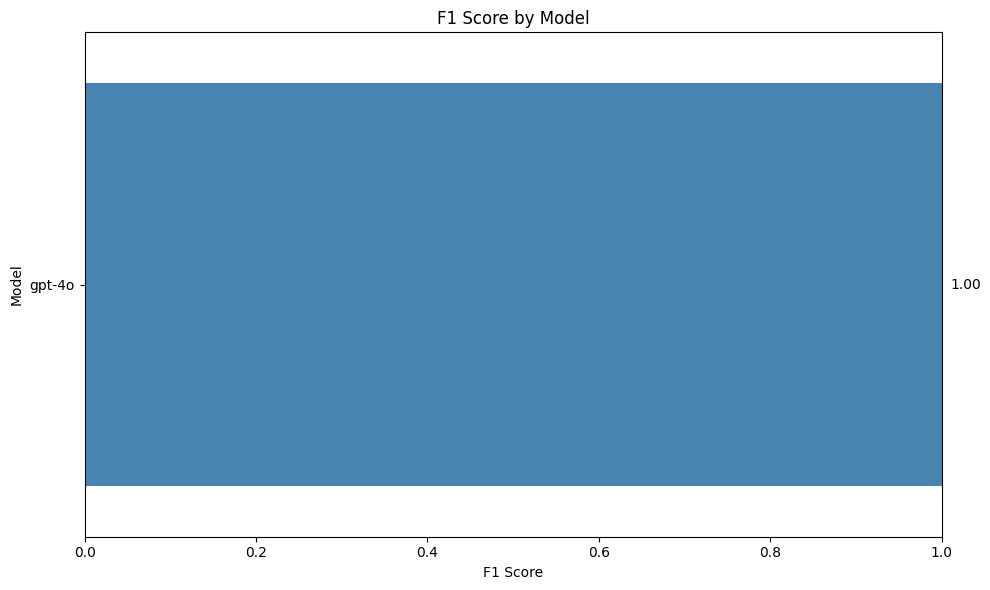

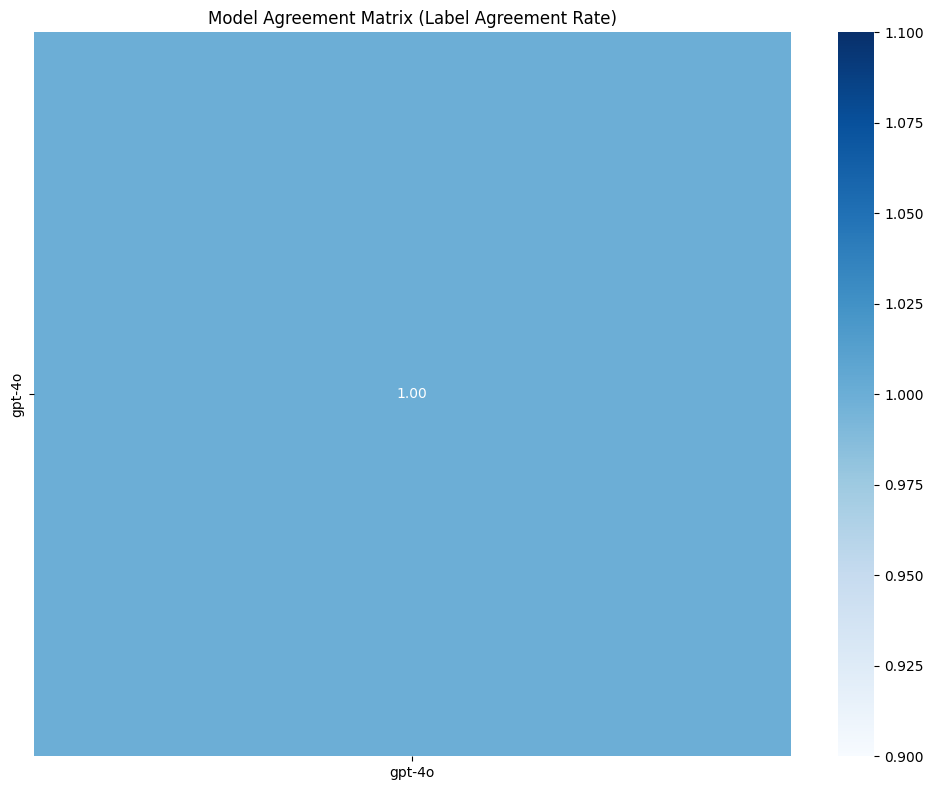

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pycm/utils.py:360: RuntimeWarning: Specified classes are not a subset of the classes in the actual and predicted vectors.
  warn(CLASSES_WARNING, RuntimeWarning)


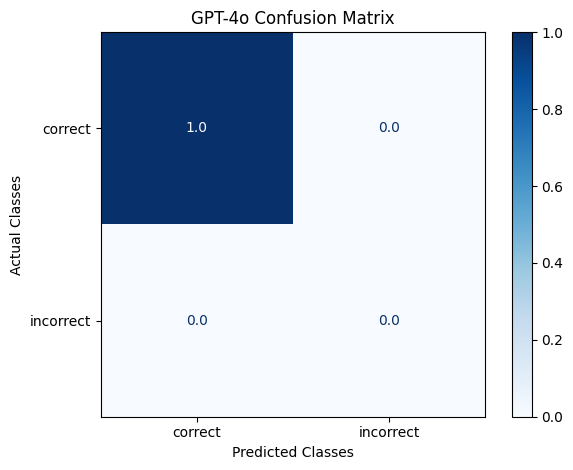

In [22]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Combine results and save
df_all_models = pd.concat(all_results, ignore_index=True)
df_all_models.to_csv("judge_results_all_models.csv", index=False)

# Compute metrics
metrics = []
models = df_all_models["model"].unique()

for model_name in models:
    df_model = df_all_models[df_all_models["model"] == model_name]

    # Keep only valid predictions and labels
    df_model = df_model[
        df_model["label"].isin(["correct", "incorrect"])
        & df_model["true_label"].isin(["correct", "incorrect"])
    ]

    # Use real ground truth, given we added some incorrect examples
    true_labels = df_model["true_label"].tolist()
    pred_labels = df_model["label"].tolist()

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, pos_label="correct", zero_division=0)
    recall = recall_score(true_labels, pred_labels, pos_label="correct", zero_division=0)
    f1 = f1_score(true_labels, pred_labels, pos_label="correct", zero_division=0)

    metrics.append(
        {
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
        }
    )

# Create dataframe and sort it
df_metrics = pd.DataFrame(metrics)
df_metrics_sorted = df_metrics.sort_values("F1 Score", ascending=False)

# Preserve order of models for plotting
model_order = df_metrics_sorted["Model"].tolist()

# Plot with fixed order
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_metrics_sorted,
    x="F1 Score",
    y="Model",
    palette="Blues_d",
    order=model_order,
)
plt.title("F1 Score by Model")
plt.xlim(0, 1)

# Add labels at correct y-axis positions
for i, model in enumerate(model_order):
    score = df_metrics_sorted[df_metrics_sorted["Model"] == model]["F1 Score"].values[0]
    ax.text(score + 0.01, i, f"{score:.2f}", va="center")

plt.tight_layout()
plt.show()

# ---- Generate agreement Matrix for models -------

# Generate a consistent ID for each example
df_all_models["example_id"] = df_all_models.groupby("model").cumcount()

# Pivot to wide format: one row per example, one column per model
df_pivot = df_all_models.pivot(index="example_id", columns="model", values="label")

# Compute agreement rates between models
agreement_matrix = pd.DataFrame(index=model_order, columns=model_order)

for m1 in model_order:
    for m2 in model_order:
        agreement = (df_pivot[m1] == df_pivot[m2]).mean()
        agreement_matrix.loc[m1, m2] = agreement

agreement_matrix = agreement_matrix.astype(float)

# ----------------------------------------
# Plot Agreement Heatmap
# ----------------------------------------

plt.figure(figsize=(10, 8))
sns.heatmap(agreement_matrix, annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("Model Agreement Matrix (Label Agreement Rate)")
plt.tight_layout()
plt.show()

# ---------------- Confusion Matrix for GPT-4o ----------------

# Filter to GPT-4o predictions and valid labels
df_4o = df_all_models[
    (df_all_models["model"] == "gpt-4o")
    & (df_all_models["label"].isin(["correct", "incorrect"]))
    & (df_all_models["true_label"].isin(["correct", "incorrect"]))
]

true_labels_4o = df_4o["true_label"].tolist()
pred_labels_4o = df_4o["label"].tolist()
rails = ["correct", "incorrect"]  # class order

# Generate and plot confusion matrix
confusion_matrix_4o = ConfusionMatrix(
    actual_vector=true_labels_4o,
    predict_vector=pred_labels_4o,
    classes=rails,
)
confusion_matrix_4o.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)
plt.title("GPT-4o Confusion Matrix")
plt.tight_layout()
plt.show()